## Determining channel importance
PSD features, theta and alpha bands only

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.decomposition import PCA

# %matplotlib inline 
%matplotlib qt


In [2]:
#Import dataset
t_auc_df = pd.read_pickle("F:\EEG-data\\think-read\\featureExtraction\AUC_only/AUC_df_1.pkl")
t_psd_df = pd.read_pickle("F:\EEG-data\\think-read\\featureExtraction\PSD_only/PSD_df_1.pkl")
a_auc_df = pd.read_pickle("F:\EEG-data\\think-read\\featureExtraction\AUC_only/AUC_df_2.pkl")
a_psd_df = pd.read_pickle("F:\EEG-data\\think-read\\featureExtraction\PSD_only/PSD_df_2.pkl")

In [3]:
def apply_SVM_channel(auc_df,psd_df):
    channels_list = []
    f1_scores = []

    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    # bestF1 = {'F1 Score':0,'dataset':'','params':''}
    # test_results = {'F1 Score':[],'dataset':[],'params':[]}
    #Create PCA instances
    pca99 = PCA(n_components=0.99, svd_solver='full')
    #Instantiate SVM gridsearch
    C_range = [1,3,10,30,100,300,1000]
    param_grid= [
                # {'C': C_range, 'kernel': ['linear']},
                {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
                ]
    scoring = {'f1_macro'}
    clf = svm.SVC()
    grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=5,refit='f1_macro')

    for i in range(32):
        #Select columns 
        y = psd_df.iloc[:,-1].values
        y1 = auc_df.iloc[:,-1].values
        psd_col_select = lambda y: [x for x in list(psd_df.columns) if "".join(("Ch",str(y),"_")) in str(x)]
        X = psd_df[psd_col_select(i+1)].values
        X1 = auc_df.iloc[:,i].values.reshape(-1,1)
        #Split into training and test sets
        for train_index, test_index in sss.split(X,y):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]
            X1_train, X1_test = X1[train_index],X1[test_index]
            y1_train, y1_test = y1[train_index],y1[test_index]
        #Fit transform on training data
        x_99_train = pca99.fit_transform(X_train)
        #Fit transform on test data
        x_99_test = pca99.transform(X_test)
        #Gridsearch
        grid99 = grid.fit(x_99_train,y_train)
        grid991 = grid.fit(X1_train,y1_train)
        #Classifiers 
        clf99 = svm.SVC(**grid99.best_params_)
        clf991 = svm.SVC(**grid991.best_params_)
        clf99.fit(x_99_train,y_train)
        clf991.fit(X1_train,y1_train)
        #y_pred
        y_99_pred = clf99.predict(x_99_test)
        y_991_pred = clf991.predict(X1_test)
        #F1 Score 
        f1Score = f1_score(y_test,y_99_pred,pos_label='T')
        f1Score1 = f1_score(y1_test,y_991_pred,pos_label='T')
        f1_scores.append(f1Score)
        f1_scores.append(f1Score1)
        #Channel list
        channels_list.append("".join(("Ch",str(i+1))))
        channels_list.append("".join(("aCh",str(i+1))))
    #Order lists 
    
    return channels_list,f1_scores 

In [4]:
t_channels,t_f1_scores = apply_SVM_channel(t_auc_df,t_psd_df)
a_channels,a_f1_scores = apply_SVM_channel(a_auc_df,a_psd_df)

In [5]:
#Sort the channels in descending order of F1 scores 
add_band = lambda channels_list,y: ["".join((x,"_",y)) for x in channels_list]
t_channels1 = add_band(t_channels,"t")
a_channels1 = add_band(a_channels,"a")

channels_list = np.array(t_channels1 + a_channels1)
f1_scores = np.array(t_f1_scores + a_f1_scores)

sorted_channels = channels_list[f1_scores.argsort()[::-1]] #in descending order, best scores first 

In [6]:
print(len(sorted_channels))

128


In [7]:
print(sorted_channels[:10])

['aCh29_t' 'Ch29_t' 'aCh19_t' 'aCh5_t' 'Ch1_a' 'Ch5_t' 'aCh28_a' 'Ch19_t'
 'aCh27_t' 'Ch22_t']


In [8]:
def create_bestCh_df(t_auc_df,a_auc_df,t_psd_df,a_psd_df,sorted_channels,no_channels):
    channels = sorted_channels[:no_channels]
    df_list = [0]*no_channels
    for (i,channel) in enumerate(channels):
        if channel[-1] == "t":
            if channel[0] == "a": #auc 
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                df_list[i] = t_auc_df.iloc[:,int(channel_no)-1]
            else: #psd
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                psd_col_select = lambda y: [x for x in list(t_psd_df.columns) if "".join(("Ch",str(y),"_")) in str(x)]
                df_list[i] = t_psd_df[psd_col_select(channel_no)]
        elif channel[-1] == "a":
            if channel[0] == "a": #auc 
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                df_list[i] = a_auc_df.iloc[:,int(channel_no)-1]
            else: #psd
                channel_no = channel[channel.find("Ch")+len("Ch"):channel.find("_")]
                psd_col_select = lambda y: [x for x in list(a_psd_df.columns) if "".join(("Ch",str(y),"_")) in str(x)]
                df_list[i] = a_psd_df[psd_col_select(channel_no)]
    df_list.append(t_auc_df.iloc[:,-1])
    return pd.concat(df_list,axis=1)

In [9]:
def PCA_CV_SVM(bestChdf):
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    # bestF1 = {'F1 Score':0,'dataset':'','params':''}
    # test_results = {'F1 Score':[],'dataset':[],'params':[]}
    #Create PCA instances
    pca99 = PCA(n_components=0.999, svd_solver='full')
    #Instantiate SVM gridsearch
    C_range = [1,3,10,30,100,300,1000]
    param_grid= [
                # {'C': C_range, 'kernel': ['linear']},
                {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
                ]
    scoring = {'f1_macro'}
    clf = svm.SVC()
    grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=5,refit='f1_macro')
    y = bestChdf.iloc[:,-1].values
    X = bestChdf.iloc[:,:-1].values
    #Split into training and test sets
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X[train_index],X[test_index]
        y_train, y_test = y[train_index],y[test_index]
    #Fit transform on training data
    x_99_train = pca99.fit_transform(X_train)
    #Fit transform on test data
    x_99_test = pca99.transform(X_test)
    #Gridsearch
    grid99 = grid.fit(x_99_train,y_train)
    #Classifiers 
    clf99 = svm.SVC(**grid99.best_params_)
    clf99.fit(x_99_train,y_train)
    #y_pred
    y_99_pred = clf99.predict(x_99_test)
    #F1 Score 
    f1Score = f1_score(y_test,y_99_pred,pos_label='T')
    return f1Score



In [10]:
channels_f1Scores = [0]*len(sorted_channels)
for i in range(1,len(sorted_channels)+1):
    bestCh_df = create_bestCh_df(t_auc_df,a_auc_df,t_psd_df,a_psd_df,sorted_channels,i)
    channels_f1Scores[i-1] = PCA_CV_SVM(bestCh_df)

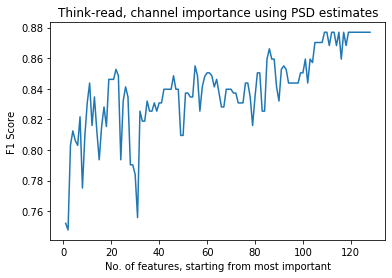

In [11]:
fig,ax = plt.subplots()
ax.plot(np.linspace(1,128,128),channels_f1Scores)
ax.set_xlabel("No. of features, starting from most important")
ax.set_ylabel("F1 Score")
ax.set_title("Think-read, channel importance using PSD estimates")
# ax.set_xticks(np.linspace(1,128,15))
plt.show()

In [11]:
maxF1 = max(channels_f1Scores)
print("Highest F1 score:",maxF1)

Highest F1 score: 0.8769230769230768


In [12]:
maxF1_channels = sorted_channels[:np.array(channels_f1Scores).argmax()]
print("No. of channels used to obtain highest F1 score:", len(maxF1_channels))
print("Channels used:",maxF1_channels)

No. of channels used to obtain highest F1 score: 108
Channels used: ['aCh29_t' 'Ch29_t' 'aCh19_t' 'aCh5_t' 'Ch1_a' 'Ch5_t' 'aCh28_a' 'Ch19_t'
 'aCh27_t' 'Ch22_t' 'aCh1_a' 'Ch1_t' 'aCh28_t' 'aCh20_t' 'aCh22_t'
 'Ch28_t' 'aCh26_t' 'Ch28_a' 'Ch15_t' 'aCh15_t' 'aCh1_t' 'aCh29_a'
 'Ch26_t' 'Ch5_a' 'aCh5_a' 'Ch13_t' 'Ch20_t' 'Ch29_a' 'aCh13_t' 'Ch31_t'
 'aCh17_t' 'Ch17_t' 'aCh16_t' 'aCh31_t' 'Ch27_t' 'aCh21_t' 'aCh18_t'
 'Ch21_t' 'Ch2_t' 'Ch18_t' 'aCh2_t' 'aCh11_a' 'Ch23_t' 'aCh23_t' 'aCh24_t'
 'aCh7_t' 'Ch24_t' 'Ch12_t' 'aCh11_t' 'aCh4_a' 'aCh10_t' 'aCh12_t'
 'Ch11_a' 'Ch11_t' 'Ch10_t' 'aCh30_a' 'Ch16_t' 'aCh30_t' 'aCh12_a'
 'Ch25_t' 'aCh25_t' 'aCh4_t' 'aCh24_a' 'Ch24_a' 'Ch30_t' 'Ch4_t' 'aCh3_t'
 'Ch8_t' 'aCh6_t' 'aCh8_t' 'Ch30_a' 'aCh8_a' 'Ch3_t' 'aCh31_a' 'Ch8_a'
 'Ch9_t' 'aCh9_t' 'Ch6_t' 'Ch26_a' 'Ch12_a' 'Ch4_a' 'Ch31_a' 'Ch10_a'
 'aCh10_a' 'Ch19_a' 'aCh26_a' 'aCh21_a' 'aCh15_a' 'Ch6_a' 'aCh6_a'
 'Ch27_a' 'Ch3_a' 'aCh7_a' 'aCh32_t' 'aCh14_a' 'aCh2_a' 'aCh16_a' 'Ch2_a'
 'Ch14_t' 'aCh20_

In [13]:
#Most frequently used channels 
maxF1_channelsDict = {}
for channel in maxF1_channels:
    channel = channel[channel.find("Ch"):channel.find("_")]
    if channel not in maxF1_channelsDict.keys():
        maxF1_channelsDict[channel] = 1
    else:
        maxF1_channelsDict[channel]+=1
maxF1_channelsDict = {k:v for k,v in sorted(maxF1_channelsDict.items(), key=lambda item: item[1], reverse=True)}

In [14]:
print(maxF1_channelsDict)

{'Ch29': 4, 'Ch5': 4, 'Ch1': 4, 'Ch28': 4, 'Ch22': 4, 'Ch26': 4, 'Ch31': 4, 'Ch16': 4, 'Ch2': 4, 'Ch11': 4, 'Ch24': 4, 'Ch12': 4, 'Ch4': 4, 'Ch10': 4, 'Ch30': 4, 'Ch3': 4, 'Ch8': 4, 'Ch6': 4, 'Ch14': 4, 'Ch19': 3, 'Ch27': 3, 'Ch20': 3, 'Ch15': 3, 'Ch17': 3, 'Ch21': 3, 'Ch7': 3, 'Ch13': 2, 'Ch18': 2, 'Ch23': 2, 'Ch25': 2, 'Ch9': 2, 'Ch32': 1}


In [19]:
plt.bar(range(len(maxF1_channelsDict)),maxF1_channelsDict.values())
plt.xticks(range(len(maxF1_channelsDict)),list(maxF1_channelsDict.keys()))
plt.title("Think-read, Most commonly used channels for highest F1 Score")
plt.ylabel("No. of occurence")
plt.xlabel("Channels")
plt.show()


In [22]:
#Discard channel if performs is worse, start from most important channel
Dchannels_f1Scores = [0]
Dsorted_channels = sorted_channels[:]
for i in range(len(sorted_channels)):
    no_channels = 1
    drop_channels = []
    bestCh_df = create_bestCh_df(t_auc_df,a_auc_df,t_psd_df,a_psd_df,Dsorted_channels,no_channels)
    current_f1Score = PCA_CV_SVM(bestCh_df)
    if current_f1Score>Dchannels_f1Scores[-1]:
        Dchannels_f1Scores.append(current_f1Score)
        no_channels +=1
    else:
        Dsorted_channels = np.delete(Dsorted_channels,np.where(Dsorted_channels==sorted_channels[i]))

In [9]:
#Load feature scaled datasets 
auc_df = pd.read_pickle("F:\EEG-data\\think-read\sampleSize_comparison\\featureScaled\AUC/AUC_df_0.1s.pkl")
psd_df = pd.read_pickle("F:\EEG-data\\think-read\sampleSize_comparison\\featureScaled\PSD/PSD_df_0.1s.pkl")
_,acols = auc_df.shape
_,pcols = psd_df.shape

t_auc_df = auc_df.iloc[:,:int((acols-1)/2)]
a_auc_df = auc_df.iloc[:,int((acols-1)/2):-1]
t_psd_df = psd_df.iloc[:,:int((acols-1)/2)]
a_psd_df = psd_df.iloc[:,int((acols-1)/2):-1]

y_auc = auc_df.iloc[:,-1]
y_psd = psd_df.iloc[:,-1]

In [10]:
t_channels,t_f1_scores = apply_SVM_channel(t_auc_df,t_psd_df)
a_channels,a_f1_scores = apply_SVM_channel(a_auc_df,a_psd_df)

(640, 32)

In [11]:
a_auc_df.shape

(640, 32)

In [12]:
auc_df.shape

(640, 65)